<h1 style="font-size: 40px;"><center>Likelihood of subscribing to a game related newsletter - a Knn classification model 
</center></h1>

<p style="font-size: 25px;">Project by DSCI 100 Group 45</p>

<h1><center><u>Introduction</u></center></h1>

<h3>Background Information</h3>

<p style="font-size: 18px;">A research group called The Pacific Laboratory of Artificial Intelligence at UBC, run by Frank Wood, is collecting data about how people play video games. They set up a Minecraft Server that people online can engage with, and the site collects data from their games. The collected data includes the player's gameplay, speech, and key presses and asks for the player's personal information such as email/phone number, age, gender, and experience level. The server also records the duration of the player's games. </p>

<h3>Our Research Question</h3>

<p style="font-size: 22px;"><i>Using the players dataset, can age and number of hours spent playing Minecraft predict if a player will subscribe to a game-related newsletter?</</p>

<p style="font-size: 18px;">Our Exploratory Data Analysis revealed that players with higher played_hours and players within a certain age range tend to subscribe more suggesting that they may be strong predictors, which is why they are included in our question. We are not including the experience variable as a predictor because based on preliminary analysis, there was no correlation between experience level and subscription status. Additionally, we are not including the gender variable as a predictor as it is a categorical value with no inherent ranking so to assign it a numeric value, we may create an order that could introduce bias and it would increase the complexity of our model. </p>

<p style="font-size: 18px;"> The goal of this project is to predict whether a Minecraft player will subscribe to a game-related newsletter. Since the outcome must either be "yes" or "no", it is a classification problem.
This project involves answering the clearly defined question using the players dataset. The report will provide background context, describe the dataset, outline the analytical methods used, and present results through summaries, visualizations, and formal data analysis, including interpreting the findings, and discussing their implications.</p>


<h3>Players Dataset Description</h3>

<p style="font-size: 18px;">- The dataframe has 196 observations and 7 variables</p>

| Variable | Type   | Missing Values | Description   | Potential Issues    |
|----------|--------|----------------|---------------|---------------------|
| experience| Character (categorical)| 0 | Player's self-reported experience level:<br>Pro, Veteran, Amateur, Beginner, or Regular | Experience level does not seem to correlate with subscription status. |
| subscribe| Logical (categorical)  | 0 | Indicates whether the player has an active subscription: True or False  | There is a class imbalance in the subscribe variable. |
| hashedEmail| Character (categorical)| 0 | Anonymized, unique identifier for each player’s email address | The variable names and hashedEmails will not help in the analysis of data. |
| played_hours | Double (numerical) | 0 | Total cumulative hours the player has played to one decimal place| Many users logged very little hours played on the game, causing significant outliers.<br>Does played_hours correspond to hours played in lifetime or hours played in a single game/sitting? |
| name | Character (categorical)| 0 | The player's first name | N/A |
| gender | Character (categorical)| 0 | The player's self-reported gender:<br>Male, Female, Agender, Nonbinary, Two-spirited, Prefer not to say, or Other | Variables like Age, gender, and experience are self-reported and may be inaccurate.<br>If K-NN classification with the gender variable is used, variable type needs to be converted.  |
| Age| Double (numerical)| 2 | The player's age in years | There are 2 missing values in the Age column<br>Extreme outliers, some players have values near zero. |


<h3>Potential Limitations of the Method Selected</h3>

- <p style="font-size: 18px;">Poor performance with imbalanced data
- <p style="font-size: 18px;">A poor choice of K can lead to overfitting or underfitting, resulting in a weaker model.
- <p style="font-size: 18px;">K-nn classification can be slow to process data with too many predictive variables. 
- <p style="font-size: 18px;">Sensitivity to outliers (especially if K is small, because predictions rely on neighbors).

<h1><center><u>Methods and Results</u></center></h1>

<h3>Reading in the Data</h3>

In [3]:
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [4]:
players_raw <- read.csv ("https://raw.githubusercontent.com/RealBabyPotato/DSCI-100-Final-Project/refs/heads/main/players%20(2).csv")
players_initial <- players_raw|>
head(10)
players_initial

,experience,subscribe,hashedEmail,played_hours,name,gender,Age
,<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<int>
1,Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
2,Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
3,Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
4,Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
5,Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
6,Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17
7,Regular,TRUE,8e594b8953193b26f498db95a508b03c6fe1c24bb5251d392c18a0da9a722807,0.0,Luna,Female,19
8,Amateur,FALSE,1d2371d8a35c8831034b25bda8764539ab7db0f63938696917c447128a2540dd,0.0,Emerson,Male,21
9,Amateur,TRUE,8b71f4d66a38389b7528bb38ba6eb71157733df7d1740371852a797ae97d82d1,0.1,Natalie,Male,47


<h3>Summary Stats</h3>

In [5]:
players_mean <- players_raw |>
    select(Age, played_hours)|>
    map(mean, na.rm = TRUE)
    players_mean

subscribe_percentage <- nrow(players_raw)
players_raw |>
  group_by(subscribe) |>
  summarize(count = n())

$Age
[1] 21.13918

$played_hours
[1] 5.845918

subscribe,count
<lgl>,<int>
FALSE,52
TRUE,144


<h3>Wrangling the Data for Analysis</h3>

In [6]:
players <- players_raw |>
    select(subscribe, played_hours, Age) |>
    mutate(subscribe = as_factor(subscribe))

glimpse(players)

Rows: 196
Columns: 3
$ subscribe    <fct> TRUE, TRUE, FALSE, TRUE, TRUE, TRUE, TRUE, FALSE, TRUE, T…
$ played_hours <dbl> 30.3, 3.8, 0.0, 0.7, 0.1, 0.0, 0.0, 0.0, 0.1, 0.0, 1.6, 0…
$ Age          <int> 9, 17, 17, 21, 21, 17, 19, 21, 47, 22, 23, 17, 25, 22, 17…


<h3>Visualizations</h3>

Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”


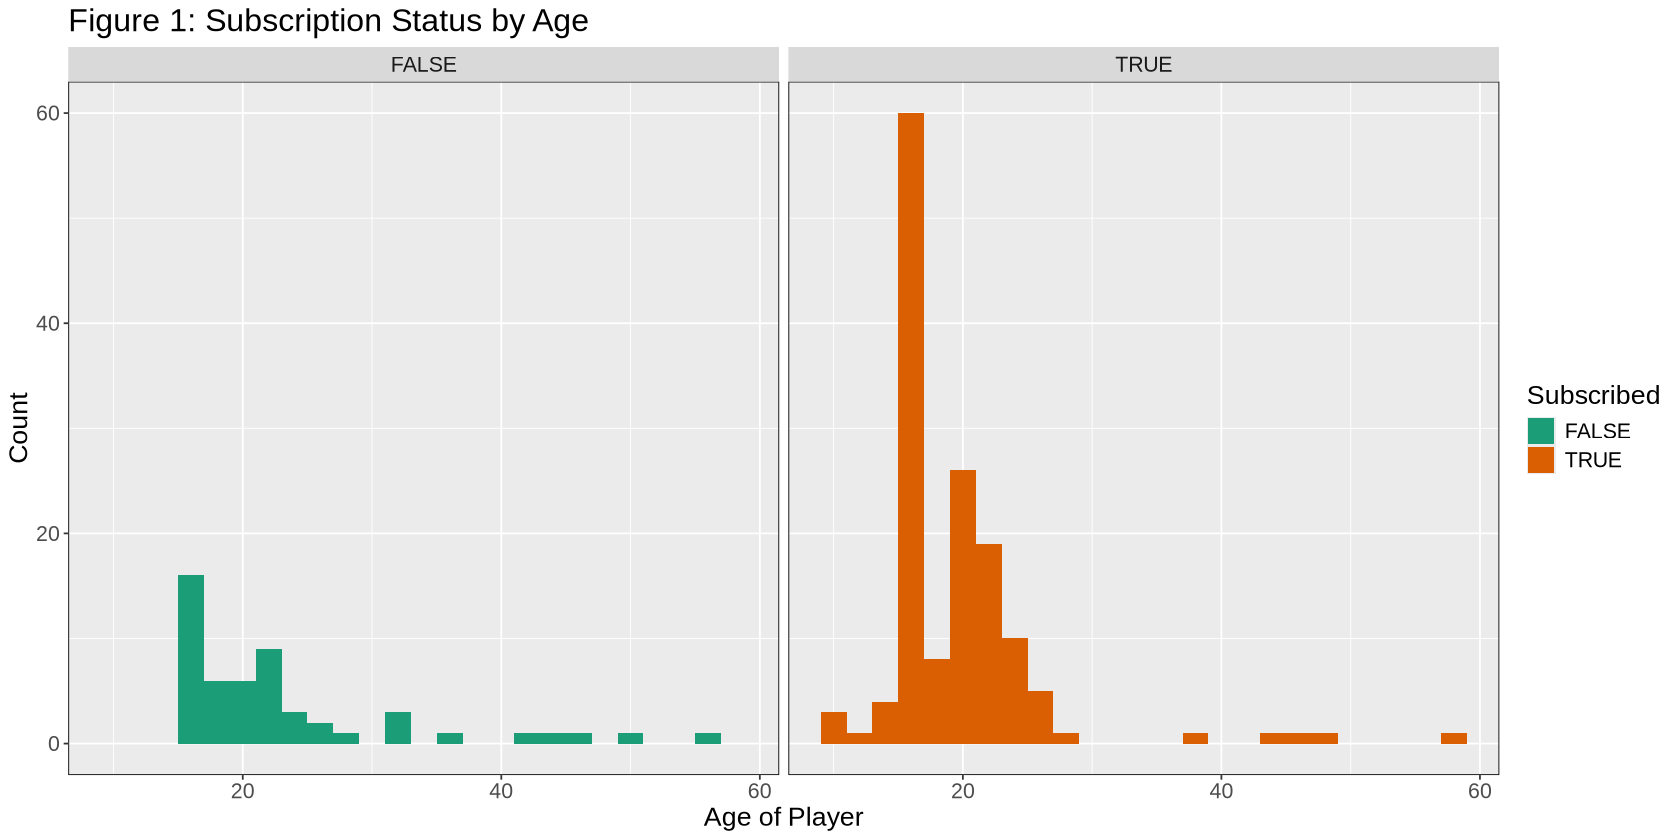

In [38]:
options(repr.plot.width = 14, repr.plot.height = 7)

age_plot <- players_raw |>
ggplot(aes(x = Age, fill = subscribe)) +
geom_histogram(binwidth = 2) +
facet_wrap(~subscribe) +
scale_fill_brewer(palette = "Dark2") +
labs(title = "Figure 1: Subscription Status by Age",
     x = "Age of Player",
     y = "Count",
     fill = "Subscribed") +
theme(text = element_text(size = 16)) +
  theme(panel.border = element_rect(color = 'black', 
                                    fill = NA))

age_plot

<p style="font-size: 18px;"> <b>Figure 1:</b> The visualization above is a faceted histogram that plots the age distribution of players based on their subscription status. In this faceted histogram, almost all of the players are in the late teens to early 20s, making the overall age distribution extremely skewed. It is also clear that the majority of all players, regardless of age, are subscribed to the game-related newsletter. Furthermore, there seems to be a trend that players who are older are less likely to be subscribed to the newsletter compared to younger players. However, this pattern could simply be due to the lack of data points that are available for older players (over age 30), causing the data to be inaccurate. </p>

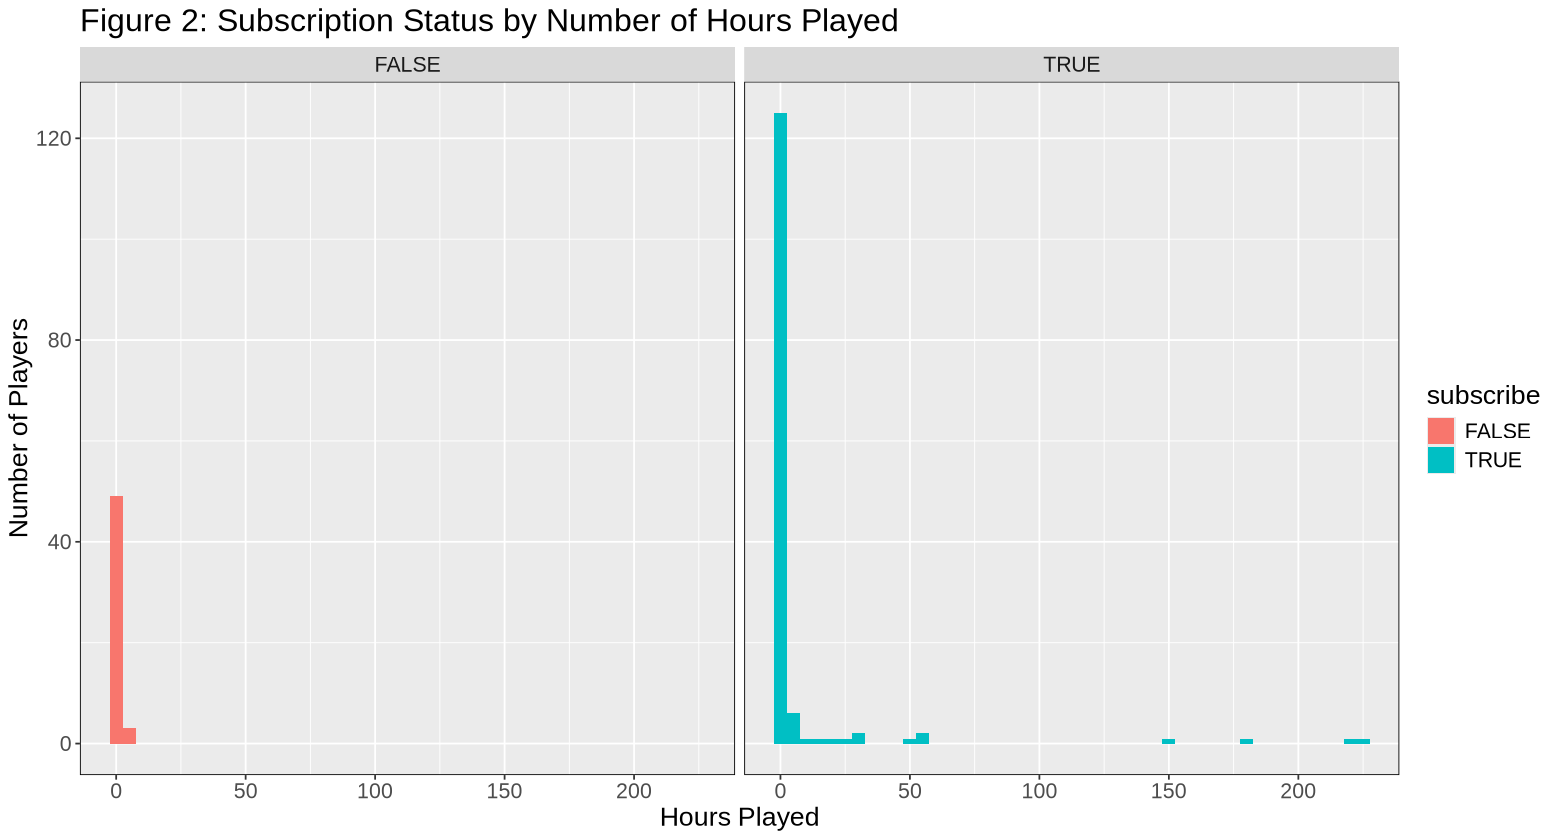

In [39]:
options(repr.plot.height = 7, repr.plot.width = 13)

hours_played_plot <- players_raw |>
ggplot(aes(x = played_hours, fill = subscribe)) +
geom_histogram(binwidth = 5) +
facet_wrap(~subscribe) +
labs(x = "Hours Played",
     y = "Number of Players",
     title = "Figure 2: Subscription Status by Number of Hours Played") +
theme(text = element_text(size = 16)) +
  theme(panel.border = element_rect(color = 'black', 
                                    fill = NA))

hours_played_plot

<p style="font-size: 18px;"><b>Figure 2:</b> This visualization is a faceted histogram comparing the distribution of hours played based on their subscription status. The left panel shows that non-subscribers are exclusively players that have minimal hours played, with all of the data points at around zero hours. On the other hand, even though the plot is centered around zero for subscribed players, this is a result of the vast majority of all data points being centered around zero hours played. However, when we look more closely, we can see that all of the players who had more than 10 hours played were all subscribed, indicating that there is indeed a trend between hours played and subscription status.</p>

<h3> Method Description</h3>

<p style="font-size: 18px;"> We will use <b>k-nn classification</b> to answer the predictive question on the players.csv dataset. This method was chosen because we will predict a categorical class (subscribed vs not subscribed) based on 2 observations: age and played_hours. Given our small number of predictors and strong dataset size, K-NN is computationally feasible, and requires few assumptions about the underlying data distribution. </p>

<p style="font-size: 18px;">  For this method, it is assumed that the data reported is accurate such as the self-reported experience level for each player. Since distance is calculated using the variables, an unstandardized analysis of this data would make the played_hours variable dominate the distance calculation. Thus, we <b>must</b> normalize/scale all quantitative features to a similar range. We must also perform mean imputation to account for N/A entries for the predictor variables. </p>

<ol style="font-size: 18px;">We will use the following steps in our analysis: <br> <br>
<li>Import tidymodels to use the K-nearest neighbours algorithm</li>
<li>Select the columns needed (age, played_hours, subscribe)</li>
<li>Set the seed for reproducibility </li>
<li>Split data into training and testing set with 80% in training set and 20% in testing set </li>
<li>Center and scale the data</li>
<li>Split the training set into a training set and a validation set using 8-fold cross-validation (arbitrarily chosen)</li>
<li>Tune the classifier to find the best value of K that gives us the highest accuracy and fit the model using the training data.</li>
<li>Use that value of K in a workflow with predictor values of age and played_hours to predict the class of subscribers on the test set. </li>
<li>Evaluate the accuracy, precision, and recall of the model using confusion matrices.</li> </ol>


<h3>K-nn Classification Model</h3>

In [9]:
library(tidymodels)

set.seed(1)

── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks readr::spec()
✖ recipes::step()   masks stats::step()
• Learn how to get started at https://www.tidymodels.org/start/




<h4>Splitting The Data </h4>

In [10]:
players_split <- initial_split(players, prop = 0.8, strata = subscribe)
players_train <- training(players_split)
players_test <- testing(players_split)

nrow(players_train)
nrow(players_test)

[1] 156

[1] 40

<h4> Recipe, Spec, and Workflow </h4>

In [11]:
players_recipe <- recipe(subscribe ~ ., data = players_train) |>
    step_impute_mean(all_numeric_predictors()) |> # n/a age values
    step_scale(all_predictors()) |>
    step_center(all_predictors())

knn_spec <- nearest_neighbor(neighbors = tune(), weight_func = "rectangular") |>
    set_engine("kknn") |>
    set_mode("classification")

knn_workflow <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(knn_spec)

<h4>Cross-Validation </h4>

In [12]:
players_vfold <- vfold_cv(players_train, v = 8, strata = subscribe) 

k_grid <- tibble(neighbors = seq(1, 30, by = 1))

knn_tune_results <- knn_workflow |>
    tune_grid(resamples = players_vfold, grid = k_grid) |>
    collect_metrics()

accuracies <- knn_tune_results |> 
    filter(.metric == "accuracy")

head(accuracies, 10)

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.4674812,8,0.03023279,Preprocessor1_Model01
2,accuracy,binary,0.4674812,8,0.03023279,Preprocessor1_Model02
3,accuracy,binary,0.5319549,8,0.02218284,Preprocessor1_Model03
4,accuracy,binary,0.5454104,8,0.02225401,Preprocessor1_Model04
5,accuracy,binary,0.5908365,8,0.02242329,Preprocessor1_Model05
6,accuracy,binary,0.5842575,8,0.02384187,Preprocessor1_Model06
7,accuracy,binary,0.6343202,8,0.01557696,Preprocessor1_Model07
8,accuracy,binary,0.6343202,8,0.01557696,Preprocessor1_Model08
9,accuracy,binary,0.6231046,8,0.02942345,Preprocessor1_Model09


<h4> Graphing K via Cross-Validation </h4>

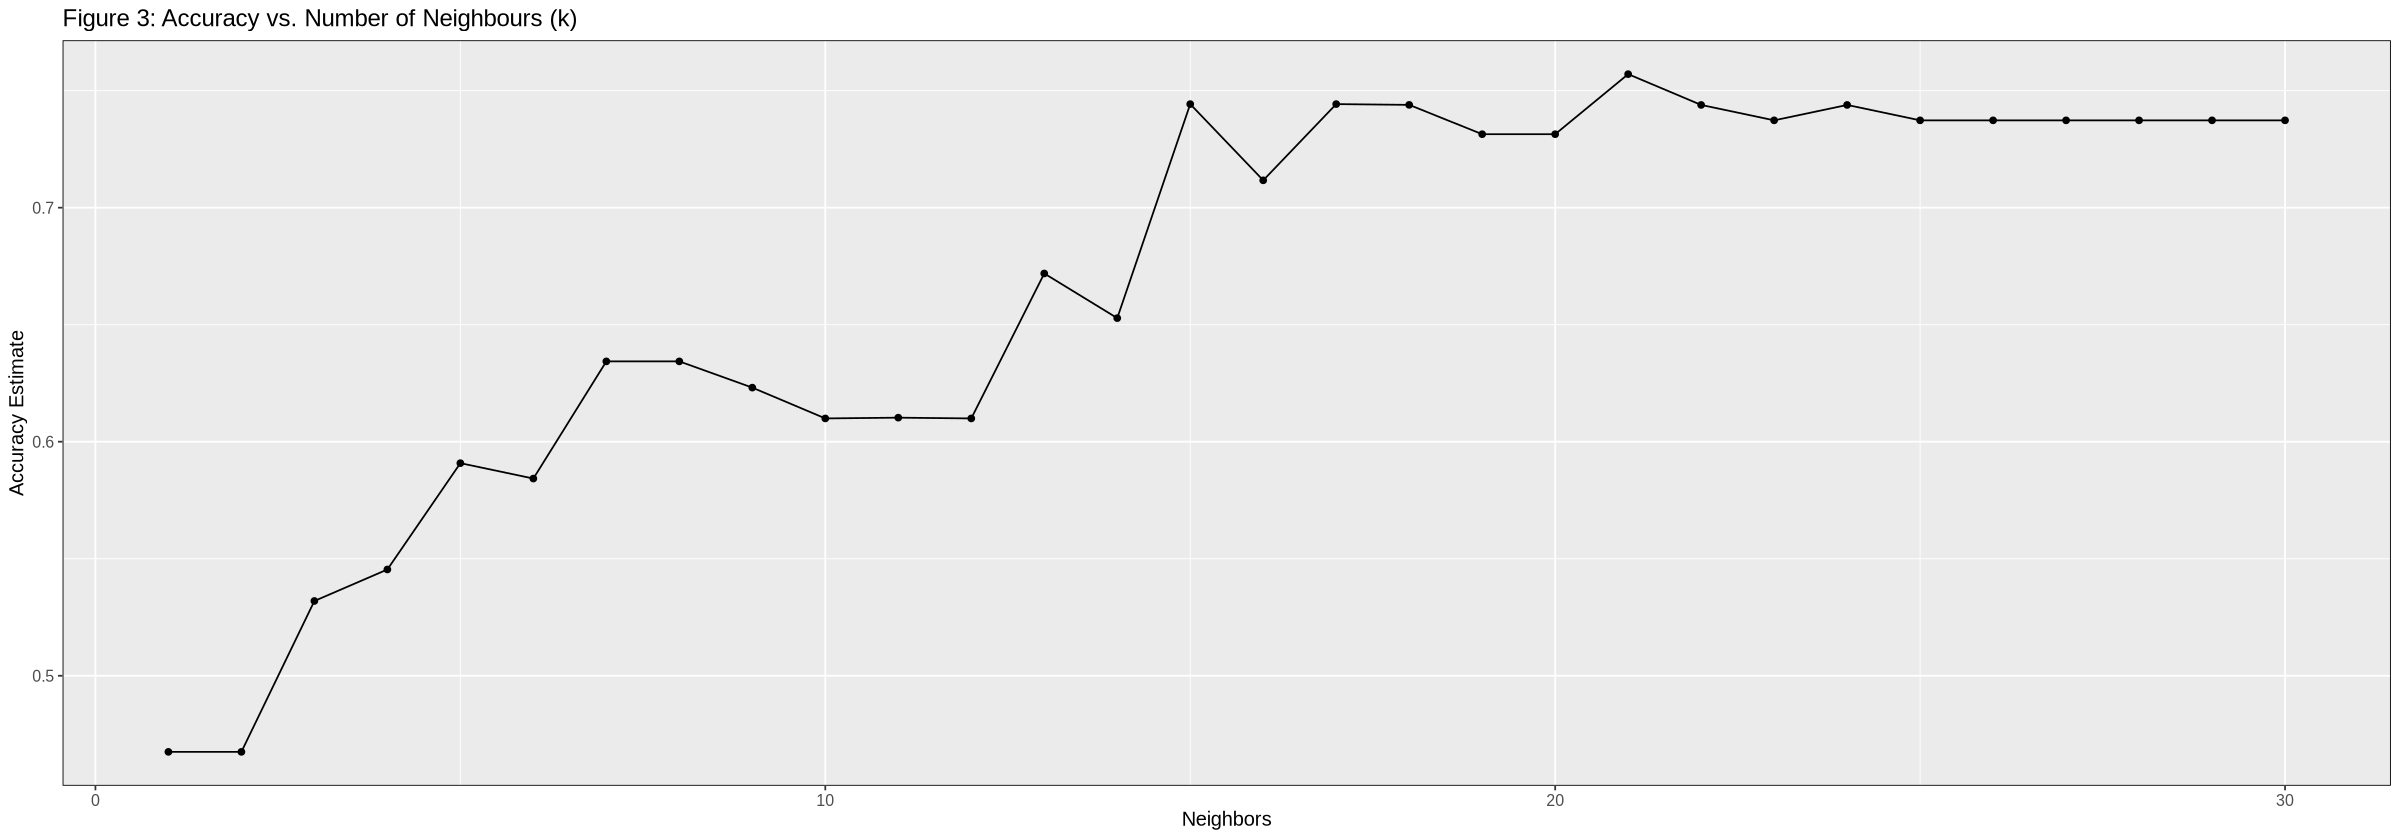

In [35]:
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate", title = "Figure 3: Accuracy vs. Number of Neighbours (k)") +
    theme(text = element_text(size = 12)) +
  theme(panel.border = element_rect(color = 'black', 
                                    fill = NA))

accuracy_vs_k

<p style="font-size: 18px;"> <b>Figure 3:</b> The visualization above is a line graph that shows how the accuracy of our K-nn classification model changes as the number of neighbours (k) changes. From the plot, it is observed that accuracy generally increases with higher values of k, and the highest accuracy happens at k = 21. This indicates that our model has the highest accuracy when using 21 neighbours. </p>

<h4> Picking the best K </h4>

In [14]:
best_k <- accuracies |>
        arrange(desc(mean)) |>
        head(1) |>
        pull(neighbors)

best_k

[1] 21

<h4> Tuning and Fitting the Model </h4>

In [15]:
players_spec_tuned <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
  set_engine("kknn") |>
  set_mode("classification")

players_fit <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(players_spec_tuned) |>
  fit(data = players_train)

players_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
3 Recipe Steps

• step_impute_mean()
• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(21,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2628205
Best kernel: rectangular
Best k: 21

<h4>Model Accuracy, Precision, and Recall </h4>

In [16]:
players_predictions <- predict(players_fit, players_test) |>
    bind_cols(players_test)

print("Model Levels:")
players_predictions |> pull(subscribe) |> levels()

print("Model Accuracy:")
players_predictions |>
    metrics(truth = subscribe, estimate = .pred_class) |>
    filter(.metric == "accuracy")

print("Model Precision:")
players_predictions |>
    precision(truth = subscribe, estimate = .pred_class, event_level = "second")

print("Model Recall:")
players_predictions |>
    recall(truth = subscribe, estimate = .pred_class, event_level = "second")

[1] "Model Levels:"


[1] "FALSE" "TRUE"

[1] "Model Accuracy:"


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.725


[1] "Model Precision:"


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.7368421


[1] "Model Recall:"


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.9655172


<h4> Confusion Matrix </h4>

In [17]:
confusion <- players_predictions |>
        conf_mat(truth = subscribe, estimate = .pred_class)

confusion

          Truth
Prediction FALSE TRUE
     FALSE     1    1
     TRUE     10   28

<h4> Identifying Majority Classifier in Training Set</h4>

In [18]:
player_proportions <- players_train |>
    group_by(subscribe) |>
    summarize(n = n()) |>
    mutate(percent = 100*n/nrow(players_train))
player_proportions

subscribe,n,percent
<fct>,<int>,<dbl>
FALSE,41,26.28205
TRUE,115,73.71795


<h4>Visualizing Model Efficacy</h4> 

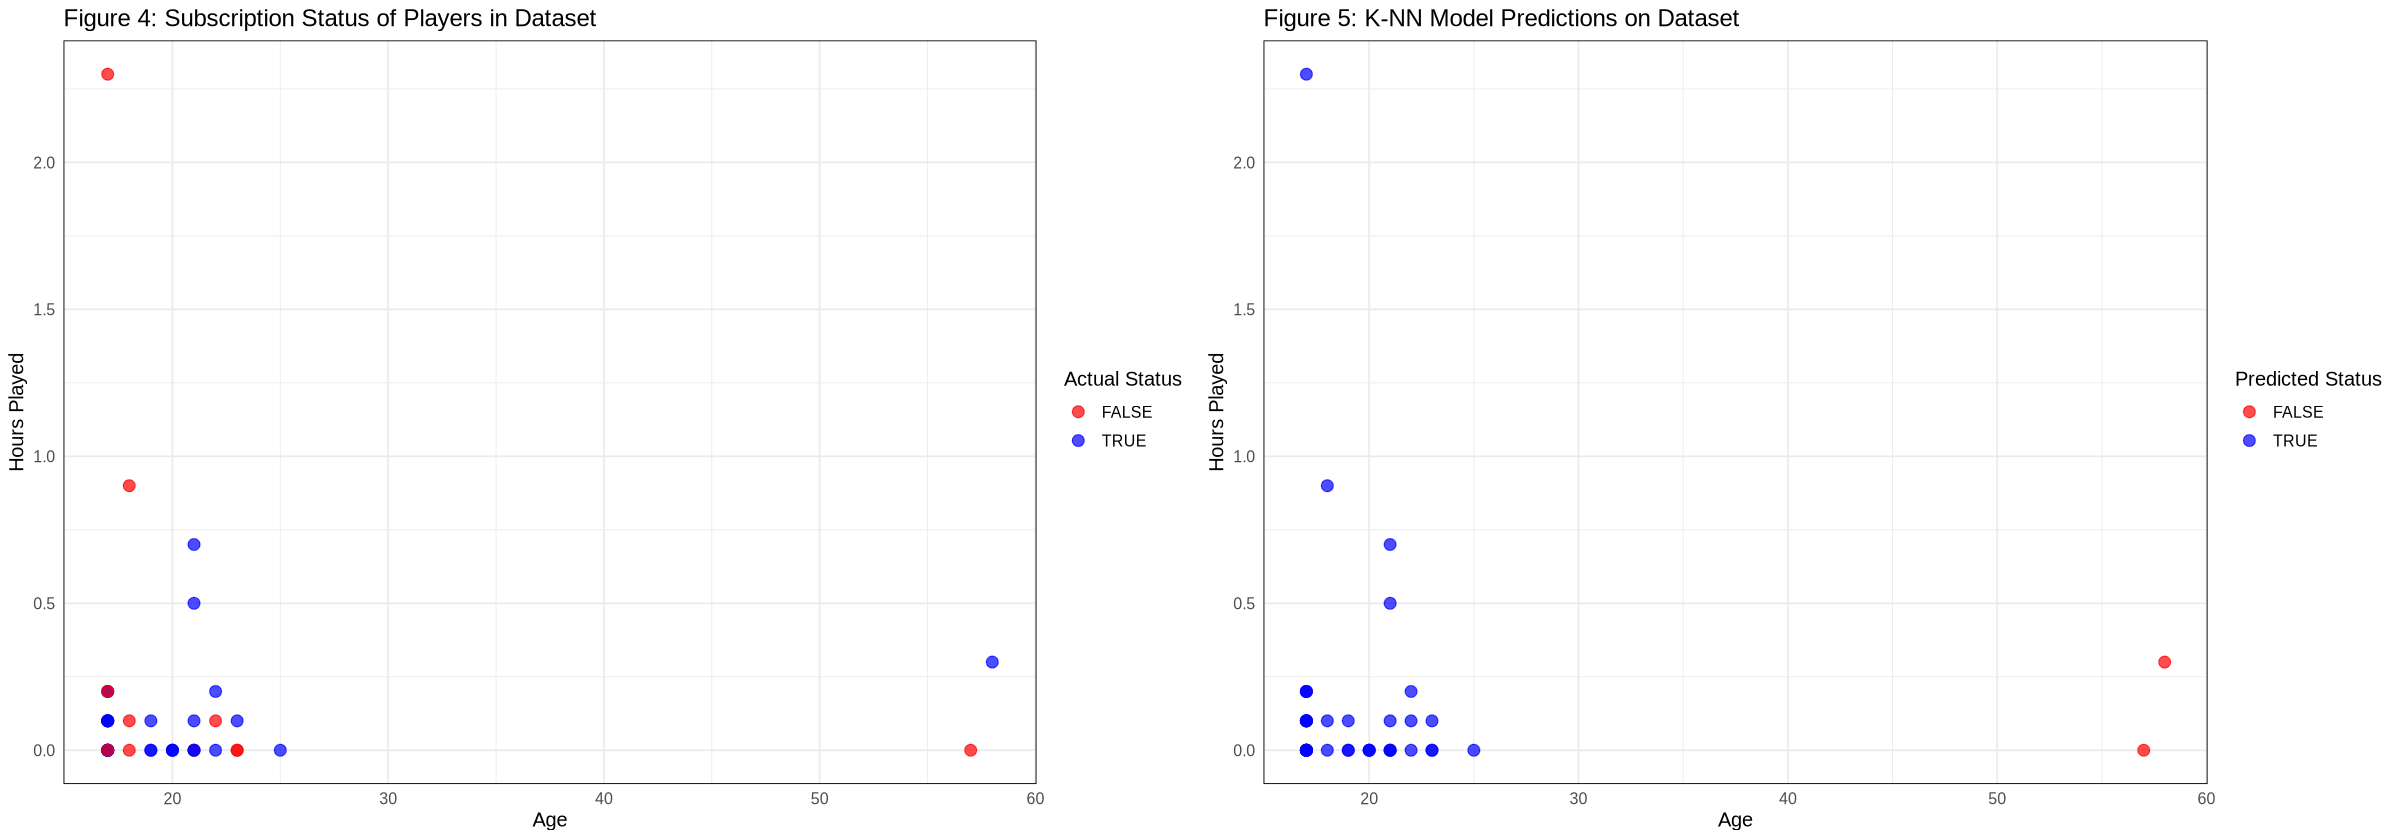

In [43]:
library(cowplot)
plot_actual <- ggplot(players_predictions, aes(x = Age, y = played_hours, color = subscribe)) +
  geom_point(alpha = 0.7, size = 3) +
  scale_color_manual(values = c("FALSE" = "red", "TRUE" = "blue")) +
  labs(title = "Figure 4: Subscription Status of Players in Dataset",
       x = "Age",
       y = "Hours Played",
       color = "Actual Status") +
  theme_minimal()+
 theme(text = element_text(size = 12))+
  theme(panel.border = element_rect(color = 'black', 
                                    fill = NA))

plot_predicted <- ggplot(players_predictions, aes(x = Age, y = played_hours, color = .pred_class)) +
  geom_point(alpha = 0.7, size = 3) +
  scale_color_manual(values = c("FALSE" = "red", "TRUE" = "blue")) +
  labs(title = "Figure 5: K-NN Model Predictions on Dataset",
       x = "Age",
       y = "Hours Played",
       color = "Predicted Status") +
  theme_minimal() +
 theme(text = element_text(size = 12))+
  theme(panel.border = element_rect(color = 'black', 
                                    fill = NA))


options(repr.plot.height = 7, repr.plot.width = 20)
plot_grid(plot_actual, plot_predicted, ncol = 2)


<p style="font-size: 18px;"> <b>Figure 4:</b> A scatterplot that displays the subscription status of players in the original dataset, with age on the x-axis and hours played on the y-axis. There are 13 distinctly blue points (TRUE class) and 7 distinctly orange points (FALSE class) observed (2 additional points are not categorized due to color ambiguity). </p>

<p style="font-size: 18px;"> <b>Figure 5:</b> A scatterplot that displays our K-nn classification model's predicitons on subscribtion status for players in the original dataset, with age on the x-axis and hours played on the y-axis. There are 20 distintly blue points (TRUE class) and 2 distinctly orange points (FALSE class) observed. This graph, relative to Figure 4, shows that our model is overpredicting the TRUE class. </p>

<h1><center><u>Discussion</u></center></h1>

<h3> Summary of what was found: </h3>

<p style="font-size: 18px;"> We found that our K-NN classification model predicts the likelihood of players subscribing to a game related newsletter with an accuracy of 72.5%, precision of 73.7% and recall of 96.6%. Based on these numbers, we believe that our predictor variables, age and played_hours do not have a strong correlation to subscription status. Our model is solid because our recall was satisfactory, while the accuracy is only slightly less than the majority classifier,  and an accuracy ~ 70 % is not bad for studies on video games and human behavior prediction. However, it could be better because the model does not outperform the baseline classifier, and does not capture meaningful patterns for the subscription status. This suggests that additional variables are needed to build a more effective predictive model. Additionally, there is a significant class imbalance in the subscription status. Within our training set, out of 156 observations, 115 of them were “TRUE” (73.7%) and only 41 were “FALSE” (26.3%). Given this fact, a baseline model that always predicts “TRUE” would achieve an accuracy of 73.7% on the data provided. As such, we tried to upsample the False label in order to avoid True label overrepresentation in the prediction, however, with this change, the accuracy, precision, and recall decreased significantly. This can be explained by  an unbalanced split or poor predictor variables, which prompted us  to test different training and testing splits. However, these different splits only lowered the accuracy, precision, and recall. Therefore, it was concluded that the model lacks informative predictors, so balancing the classes does not actually help it distinguish between them, and upsampling was not needed.</p>


<h3> Were the results expected?</h3>

<p style="font-size: 18px;"> We expected the majority classifier to have an accuracy of 73.7% based on the proportions of “TRUE” and “FALSE”. Our Knn classification model only had an accuracy of 72.5% which is slightly below the baseline. Since the accuracy was lower than what we expected, the model is not effective at predicting subscription status. However, this outcome was expected, as before training the model, we determined that the predictor variables (age and played_hours) showed substantial overlap in data. Because both groups looked very similar in the visualizations (figure 1 and figure 2), we did not expect the model to proficiently separate the subscribers from the non-subscribers, as the two categories are too similar, which confuses the model (which needs distinct distributions to work well), and therefore lowers the accuracy of the predictions. Through our exploratory data analysis we noticed that all the variables that were given had this significant overlap, and as such we were limited in our selection of predictor variables  even if we predicted that the model would not perform well.</p>




<h3> Significance/Impacts from the findings:</h3>

- <p style="font-size: 18px;">The fact that the model does not outperform the baseline indicates that age and played_hours alone are not strong predictors of subscription status. This is important because it shows that the current data that is being recorded is not enough to understand player engagement or subscription behavior.

- <p style="font-size: 18px;">The findings highlight the challenges of modeling player behavior with limited features. The overlap between subscribers and non-subscribers in age and played_hours suggests that player engagement is influenced by more complex, unobserved factors. This insight is significant as it leads to the conclusion that there is a need for collecting behavioral or preference-based data, which could improve model performance.

- <p style="font-size: 18px;">Currently, the model does not perform better than the baseline classifier, so it can not reliably identify potential subscribers. However, if the accuracy is improved by adding additional variables, it can lead to improved and efficient targeted marketing to increase the number of subscriptions. </p>


<h3> Future questions this could lead to:</h3>

- <p style="font-size: 18px;">Are there additional measurable variables that can improve the prediction?
- <p style="font-size: 18px;">For played_hours, does the time of day or day of the week impact the subscription status?
- <p style="font-size: 18px;">In addition to predicting if a player subscribes, can we predict <b>when</b> a player is most likely to subscribe based on the variables? </p>

<h1><center><u>References</u></center></h1>

Bobbitt, Z. (2024, May 24). How to Add Panel Border to ggplot2. Statology. (https://www.statology.org/ggplot2-panel-border/)

olawanletjoel. (2022, August 4). HTML Font Size – How to Change Text Size with an HTML Tag. FreeCodeCamp.org. (https://www.freecodecamp.org/news/how-to-change-text-size-in-html/)

Peng, T. T., Trevor Campbell, and Melissa Lee Foreword by Roger. (n.d.). Data Science. In datasciencebook.ca. (https://datasciencebook.ca/index.html)

‌